In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [67]:
def legendre_polynomial_basis(n: int, x: float) -> np.array:
    """
    Creates the Legendre polynomial basis up to degree n-1.

    Parameters:
        n (int): Degree to which the Legendre polynomial is evaluated.
        x (float): Point at which the Legendre polynomial is evaluated.

    Returns:
        np.array: Bases of the Legendre polynomial at x.
    """
    basis = np.zeros(n)
    if n >= 1:
        basis[0] = 1.0
    if n >= 2:
        basis[1] = x
        for i in range(2, n):
            basis[i] = (2*i - 1)/i * x * basis[i-1] - (i - 1)/i * basis[i-2]
    return basis


def legendre_polynomial(n: int, point: float) -> float:
    """
    Evaluates the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the Legendre polynomial is evaluated.
        x (float): Point at which the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the n-th Legendre polynomial at x.
    """
    value = legendre_polynomial_basis(n + 1, point)[n]
    return value


def legendre_derivative(n: int, x: float) -> float:
    """
    Evaluates the derivative of the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the derivative of the Legendre polynomial is evaluated.
        x (float): Point at which the derivative of the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the derivative of tghe n-th Legendre polynomial at x.
    """
    if n == 0:
        return 0.0
    Pn = legendre_polynomial(n, x)
    Pn_1 = legendre_polynomial(n - 1, x)
    return n / (x**2 - 1.0) * (x * Pn - Pn_1)


In [68]:
def legendre_quadrature(integrand, m: int = 32) -> float:
    """
    Computes the Gauss-Legendre of a given function with arbitrary precision.

    Parameters:
        integrand (callable): Function to be integrated.
        m (int, optional): Degree of the quadrature.

    Returns:
        float: Value of the integral.
    """
    pts, wts = np.polynomial.legendre.leggauss(m)
    vals = np.array([integrand(x) for x in pts])
    return np.sum(wts * vals)


In [69]:
def affine_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [-1,1] to [a,b]

    Parameters:
        x (np.array): Interval from [-1,1]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [a,b].
    """
    return (b-a)/2 * x + (a+b)/2


def inverse_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [a,b] to [-1,1]

    Parameters:
        x (np.array): Interval from [a,b]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [-1,1].
    """
    return 2/(b-a) * x - (a+b)/(b-a)

[ 0.05000027 -0.13499912  0.18250177 -0.18724671  0.15998115 -0.11826556
  0.07733867 -0.04526321  0.02418771 -0.01137675  0.00598776 -0.00285132]
-5.3303975574015006e-06


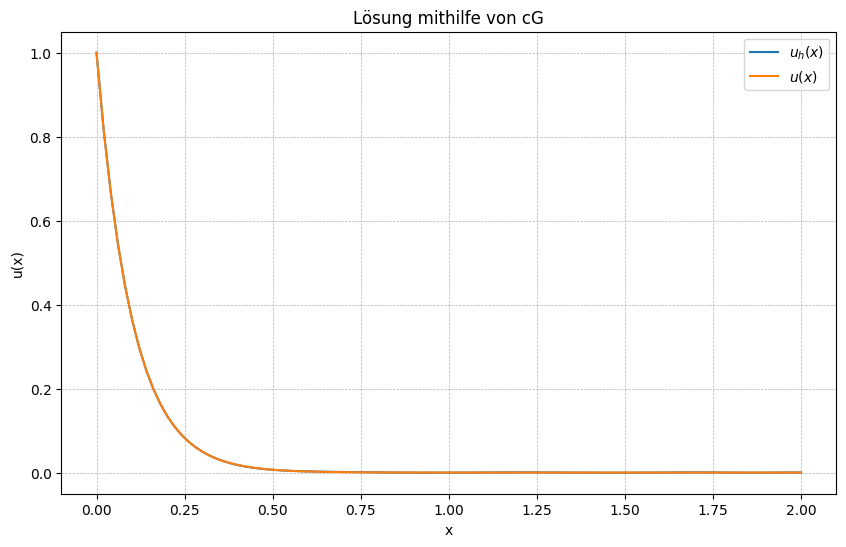

In [ ]:
def f(u: float) -> float:
    """
    RHS of the system
    """
    return -10*u


def make_residual(n: int, u0: float):
    """
    Prepares the residual of the system for the Newton-Krylov solver.

    Parameters:
        n (int): Number of dofs.
        u0 (float): initial condition.

    Returns:
        callable: Residual function for scipy's Newton-Krylov solver.
    """
    def residual(c: np.ndarray) -> np.ndarray:
        r = np.zeros(n) # initialise residual, c is the initial estimate of the constants for u
        for i in range(n - 1):
            # define function for Gauss-Legendre Quadrature
            def integrand(x: float) -> float: 
                u_val = 0.0
                du_val = 0.0
                for j in range(n):
                    Pj = legendre_polynomial(j, x) # Basis functions of solution
                    dPj = legendre_derivative(j, x) # Basis functions of RHS
                    # Linear combinations of the solution u and its derivative
                    u_val += c[j] * Pj 
                    du_val += c[j] * dPj
                return (du_val - f(u_val)) * legendre_polynomial(i, x) # test for all basis functions
            r[i] = legendre_quadrature(integrand, m=64) # Matrix entries A_ij
        u_minus1 = 0.0  # "Boundary condition" (initial value)
        for j in range(n):
            u_minus1 += c[j] * legendre_polynomial(j, -1.0) # Values at the left boundary
        r[-1] = u_minus1 - u0 # Subtract solution vector from LES
        return r
    return residual


n = 12  # number of dofs
u0 = 1.0
residual = make_residual(n, u0)
x0 = np.zeros(n)
x0[0] = u0
x = scipy.optimize.fsolve(residual, x0)
print(x)

gsize = 100
ugrid = np.linspace(-1, 1, gsize)
V = np.ndarray((gsize, n))
for i in range(gsize):
    for j in range(n):
        V[i, j#] = legendre_polynomial(j, ugrid[i]) # Vandermonde Matrix
solution = V @ x # Calculate solution from Vandermonde matrix

grid = affine_trafo(ugrid, 0, 2) # perform affine transformation to wanted interval

real_solution = np.exp(-10*grid)

print(solution[-1])

plt.figure(figsize=(10, 6))
plt.plot(grid, solution, label="$u_h(x)$")
plt.plot(grid, real_solution, label="$u(x)$")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("Lösung mithilfe von cG")
plt.show()
